# Project: Image Classification and Regression MVA - CentraleSupelec

# Vincent ATTIA

## Getting Started

In [1]:
from keras.models import Sequential
from keras.layers import Dense, Activation
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from keras.optimizers import SGD

Using TensorFlow backend.


In [2]:
def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

In [3]:
def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)

In [4]:
def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

In [5]:
def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]

In [6]:
# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

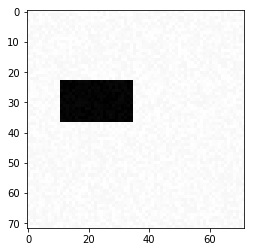

In [7]:
im = generate_a_rectangle(10, True)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

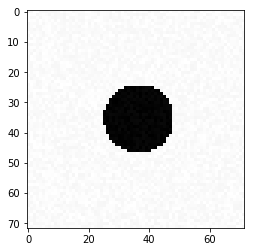

In [8]:
im = generate_a_disk(10)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

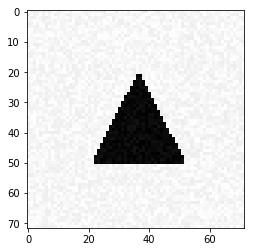

In [9]:
[im, v] = generate_a_triangle(20, False)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

Code to generate a dataset was changed in order to output as labels a matrix with 3 colums in a binary format instead of a vector including the label.

Generate_test_set_classification was also changed accordingly.

In [10]:
def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros((nb_samples, 3))
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i, category] = 1
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

In [11]:
def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    return [X_test, Y_test]

In [12]:
def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

In [13]:
def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

In [14]:
def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]

## 3 Simple Classification - stochastic gradient descent

In [15]:
[X_train, Y_train] = generate_dataset_classification(300, 20)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [16]:
X_train.shape

(300, 5184)

In [17]:
Y_train.shape

(300, 3)

In [18]:
from keras.models import Sequential
model = Sequential()

In [19]:
from keras.layers import Dense, Activation
nb_neurons = 121
model = Sequential([
  Dense(nb_neurons, input_shape=(5184,)),
  Activation('relu'),
  Dense(64),
  Activation('relu'),
  Dense(3, activation ='softmax')])

In [20]:
from keras.optimizers import SGD
sgd = SGD(lr=0.001,
          decay=1e-6, momentum=0.9,
nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics =['accuracy'])

In [21]:
model.fit(X_train, Y_train, epochs=50, batch_size=32, validation_split = 0.2)

Train on 240 samples, validate on 60 samples
Epoch 1/50
240/240 [==============================] - 0s 804us/step - loss: 1.2095 - acc: 0.3875 - val_loss: 0.9356 - val_acc: 0.5333
Epoch 2/50
240/240 [==============================] - 0s 204us/step - loss: 0.8817 - acc: 0.5708 - val_loss: 0.8522 - val_acc: 0.6333
Epoch 3/50
240/240 [==============================] - 0s 197us/step - loss: 0.7386 - acc: 0.7333 - val_loss: 0.7253 - val_acc: 0.7500
Epoch 4/50
240/240 [==============================] - 0s 198us/step - loss: 0.6140 - acc: 0.8042 - val_loss: 0.6326 - val_acc: 0.8000
Epoch 5/50
240/240 [==============================] - 0s 206us/step - loss: 0.5146 - acc: 0.8375 - val_loss: 0.5711 - val_acc: 0.8167
Epoch 6/50
240/240 [==============================] - 0s 207us/step - loss: 0.4584 - acc: 0.8500 - val_loss: 0.4966 - val_acc: 0.8000
Epoch 7/50
240/240 [==============================] - 0s 204us/step - loss: 0.4098 - acc: 0.8583 - val_loss: 0.4079 - val_acc: 0.7833
Epoch 8/50
240/24

The current neural network performs well, with an accuaracy of 1 for both the training and test set. There is therefore no overfitting.

We will now perform a test on manually generated shapes.

In [22]:
X_test = generate_a_rectangle(20)
X_test = X_test.reshape(1, X_test.shape[0])
model.predict(X_test)

array([[1., 0., 0.]], dtype=float32)

In [23]:
X_test = generate_a_disk(20)
X_test = X_test.reshape(1, X_test.shape[0])
model.predict(X_test)

array([[0., 1., 0.]], dtype=float32)

In [24]:
[X_test,_] = generate_a_triangle(20)
X_test = X_test.reshape(1, X_test.shape[0])
model.predict(X_test)

array([[0., 0., 1.]], dtype=float32)

The classifier performs well on those 3 instances

## 4 Visualization of the Solution - stochastic gradient descent

Get information regarding the shapes of all weights

In [25]:
for w in model.get_weights():
    print(w.shape)

(5184, 121)
(121,)
(121, 64)
(64,)
(64, 3)
(3,)


Visualisation of the first layer. The output doesn't seem to be comprehensible. We will also visualize further layers, more difficult to interpret.

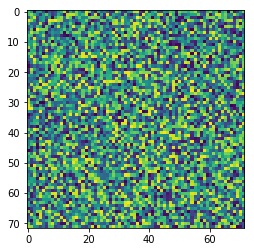

In [26]:
plt.imshow(model.get_weights()[0][:,1].reshape(72, 72))

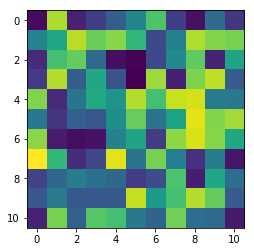

In [27]:
plt.imshow(model.get_weights()[2][:,0].reshape(11, 11))

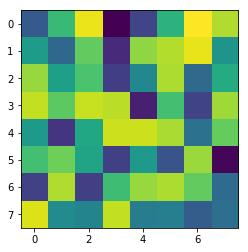

In [28]:
plt.imshow(model.get_weights()[4][:,2].reshape(8, 8))

## 3 Simple Classification - Adam optimizer

In [29]:
from keras.models import Sequential
model2 = Sequential()

from keras.layers import Dense, Activation
nb_neurons = 2500
model2 = Sequential([
    Dense(nb_neurons, input_shape=(5184,), activation= 'relu'),
    Dense(900, activation = 'relu'),
    Dense(3, activation = 'softmax')])

from keras.optimizers import Adam
adam = Adam(lr=0.0001,
            beta_1=0.9, beta_2=0.999,
            epsilon=None, decay=0.0,
            amsgrad=False)

model2.compile(loss='categorical_crossentropy', optimizer=adam, metrics =['accuracy'])

In [30]:
model2.fit(X_train, Y_train, epochs=15, batch_size=25, validation_split = 0.2)

Train on 240 samples, validate on 60 samples
Epoch 1/15
240/240 [==============================] - 3s 11ms/step - loss: 2.0857 - acc: 0.4958 - val_loss: 1.3254 - val_acc: 0.5833
Epoch 2/15
240/240 [==============================] - 2s 8ms/step - loss: 0.8738 - acc: 0.6250 - val_loss: 0.7437 - val_acc: 0.7667
Epoch 3/15
240/240 [==============================] - 2s 9ms/step - loss: 0.6393 - acc: 0.7458 - val_loss: 0.6613 - val_acc: 0.7333
Epoch 4/15
240/240 [==============================] - 2s 9ms/step - loss: 0.5617 - acc: 0.7500 - val_loss: 0.8062 - val_acc: 0.7000
Epoch 5/15
240/240 [==============================] - 2s 9ms/step - loss: 0.4527 - acc: 0.7708 - val_loss: 0.6095 - val_acc: 0.7833
Epoch 6/15
240/240 [==============================] - 2s 8ms/step - loss: 0.3612 - acc: 0.8500 - val_loss: 0.4853 - val_acc: 0.8000
Epoch 7/15
240/240 [==============================] - 2s 8ms/step - loss: 0.2737 - acc: 0.8875 - val_loss: 0.2658 - val_acc: 0.8833
Epoch 8/15
240/240 [==========

In [31]:
X_test = generate_a_rectangle(20)
X_test = X_test.reshape(1, X_test.shape[0])
model2.predict(X_test)

array([[1., 0., 0.]], dtype=float32)

In [32]:
X_test = generate_a_disk(20)
X_test = X_test.reshape(1, X_test.shape[0])
model.predict(X_test)

array([[0., 1., 0.]], dtype=float32)

In [33]:
[X_test,_] = generate_a_triangle(20)
X_test = X_test.reshape(1, X_test.shape[0])
model.predict(X_test)

array([[0., 0., 1.]], dtype=float32)

Adam optimizer works well with a low learning right. Higher values have shown to converge on a non optimal solution.

## 4 Visualization of the Solution - Adam optimizer

In [34]:
for w in model2.get_weights():
    print(w.shape)

(5184, 2500)
(2500,)
(2500, 900)
(900,)
(900, 3)
(3,)


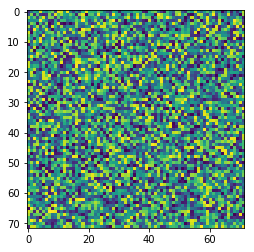

In [36]:
plt.imshow(model2.get_weights()[0][:,0].reshape(72, 72))

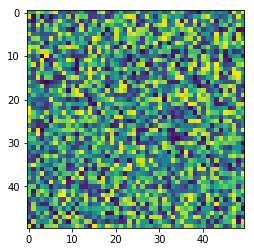

In [37]:
plt.imshow(model2.get_weights()[2][:,4].reshape(50, 50))

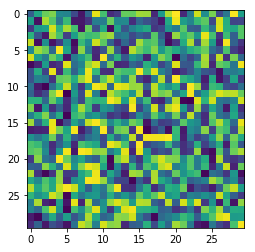

In [38]:
plt.imshow(model2.get_weights()[4][:,1].reshape(30, 30))

No output seems to be interpretable. However, in the process of finding this optimal solution, we were able to notive that under other training parameters, the weights did output interesting values.

In [39]:
from keras.models import Sequential
model3 = Sequential()

from keras.layers import Dense, Activation
nb_neurons = 2500
model3 = Sequential([
    Dense(nb_neurons, input_shape=(5184,), activation= 'relu'),
    Dense(3, activation = 'softmax')])

from keras.optimizers import Adam
adam = Adam(lr=0.01,
            beta_1=0.9, beta_2=0.999,
            epsilon=None, decay=0.0,
            amsgrad=False)

model3.compile(loss='categorical_crossentropy', optimizer=adam, metrics =['accuracy'])

In [40]:
model3.fit(X_train, Y_train, epochs=5, batch_size=32, validation_split = 0.2)

Train on 240 samples, validate on 60 samples
Epoch 1/5
240/240 [==============================] - 2s 8ms/step - loss: 9.5306 - acc: 0.3500 - val_loss: 9.1336 - val_acc: 0.4333
Epoch 2/5
240/240 [==============================] - 1s 6ms/step - loss: 10.5439 - acc: 0.3458 - val_loss: 9.1336 - val_acc: 0.4333
Epoch 3/5
240/240 [==============================] - 1s 6ms/step - loss: 10.5439 - acc: 0.3458 - val_loss: 9.1336 - val_acc: 0.4333
Epoch 4/5
240/240 [==============================] - 1s 6ms/step - loss: 10.5439 - acc: 0.3458 - val_loss: 9.1336 - val_acc: 0.4333
Epoch 5/5
240/240 [==============================] - 1s 6ms/step - loss: 10.5439 - acc: 0.3458 - val_loss: 9.1336 - val_acc: 0.4333


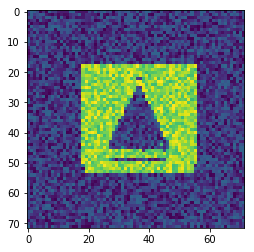

In [41]:
plt.imshow(model3.get_weights()[0][:,6].reshape(72, 72))

For instance, we can here witness that at the first level of the neural network, some neurones are clearly testing the shapes. In this particular neurone, we can discern the shapes of a triangle and a square, probably testing the pixels specific to the square.
This understandable step is not reproductible with the well-performing Adam optimizer above.

## 5 A More Difficult Classification Problem

In [42]:
[X_train, Y_train] = generate_dataset_classification(300, 20, True)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


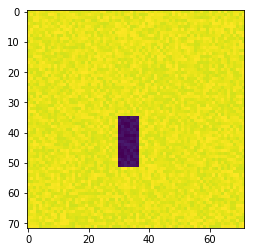

In [43]:
plt.imshow(X_train[10,:].reshape(72, 72))

In [44]:
Y_train.shape

(300, 3)

In [45]:
from keras.models import Sequential
model4 = Sequential()

from keras.layers import Dense, Activation
nb_neurons = 121
model4 = Sequential([
  Dense(nb_neurons, input_shape=(5184,)),
  Activation('relu'),
  Dense(64),
  Activation('relu'),
  Dense(3, activation ='softmax')])

from keras.optimizers import SGD
sgd = SGD(lr=0.001,
          decay=1e-6, momentum=0.9,
nesterov=True)

In [46]:
model4.compile(loss='categorical_crossentropy', optimizer=sgd, metrics =['accuracy'])

In [47]:
model4.fit(X_train, Y_train, epochs=100, batch_size=32, validation_split = 0.2)

Train on 240 samples, validate on 60 samples
Epoch 1/100
240/240 [==============================] - 0s 1ms/step - loss: 1.1812 - acc: 0.3708 - val_loss: 1.2228 - val_acc: 0.3167
Epoch 2/100
240/240 [==============================] - 0s 229us/step - loss: 1.0010 - acc: 0.4917 - val_loss: 0.9613 - val_acc: 0.4667
Epoch 3/100
240/240 [==============================] - 0s 236us/step - loss: 0.9214 - acc: 0.5333 - val_loss: 0.9757 - val_acc: 0.4167
Epoch 4/100
240/240 [==============================] - 0s 238us/step - loss: 0.8344 - acc: 0.5958 - val_loss: 1.0524 - val_acc: 0.6167
Epoch 5/100
240/240 [==============================] - 0s 256us/step - loss: 0.8531 - acc: 0.6000 - val_loss: 0.8612 - val_acc: 0.5667
Epoch 6/100
240/240 [==============================] - 0s 255us/step - loss: 0.7943 - acc: 0.6375 - val_loss: 0.9741 - val_acc: 0.5333
Epoch 7/100
240/240 [==============================] - 0s 241us/step - loss: 0.7578 - acc: 0.6375 - val_loss: 0.9947 - val_acc: 0.4833
Epoch 8/100


Epoch 61/100
240/240 [==============================] - 0s 223us/step - loss: 0.3439 - acc: 0.8958 - val_loss: 1.0151 - val_acc: 0.6833
Epoch 62/100
240/240 [==============================] - 0s 234us/step - loss: 0.3968 - acc: 0.8583 - val_loss: 0.8834 - val_acc: 0.5667
Epoch 63/100
240/240 [==============================] - 0s 215us/step - loss: 0.3556 - acc: 0.8542 - val_loss: 1.0421 - val_acc: 0.5333
Epoch 64/100
240/240 [==============================] - 0s 259us/step - loss: 0.4142 - acc: 0.8250 - val_loss: 0.7958 - val_acc: 0.6500
Epoch 65/100
240/240 [==============================] - 0s 228us/step - loss: 0.3684 - acc: 0.8333 - val_loss: 0.8148 - val_acc: 0.6500
Epoch 66/100
240/240 [==============================] - 0s 228us/step - loss: 0.3128 - acc: 0.8958 - val_loss: 0.9173 - val_acc: 0.5667
Epoch 67/100
240/240 [==============================] - 0s 227us/step - loss: 0.3263 - acc: 0.8833 - val_loss: 0.9019 - val_acc: 0.5833
Epoch 68/100
240/240 [==========================

In [48]:
[X_test, Y_test] = generate_test_set_classification()

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [49]:
Y_test.shape

(300, 3)

In [50]:
model4.evaluate(X_test, Y_test)

300/300 [==============================] - 0s 87us/step


[1.2207681115468343, 0.566666667064031]

The test accuracy is of 58%. To get a better result, we will now try to add a convolutional layer.

In [51]:
[X_train, Y_train] = generate_dataset_classification(1000, 20, True)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990


In [52]:
X_train.shape

(1000, 5184)

In [53]:
X_train = X_train.reshape(1000, 72, 72)

In [54]:
#reshape data to fit model
X_train = X_train.reshape(1000, 72, 72, 1)

In [55]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten
#create model
model5 = Sequential()
#add model layers
model5 = Sequential([
    Conv2D(64, kernel_size=3, activation='relu', input_shape=(72, 72, 1)),
    Conv2D(32, kernel_size=3, activation='relu'),
    Flatten(),
    Dense(3, activation='softmax')])

In [56]:
#compile model using accuracy to measure model performance
model5.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [57]:
model5.fit(X_train, Y_train, epochs=15, validation_split = 0.2)

Train on 800 samples, validate on 200 samples
Epoch 1/15
800/800 [==============================] - 10s 13ms/step - loss: 1.3533 - acc: 0.4500 - val_loss: 0.8024 - val_acc: 0.7000
Epoch 2/15
800/800 [==============================] - 9s 11ms/step - loss: 0.6571 - acc: 0.7300 - val_loss: 0.6597 - val_acc: 0.7300
Epoch 3/15
800/800 [==============================] - 9s 11ms/step - loss: 0.4933 - acc: 0.8038 - val_loss: 0.6513 - val_acc: 0.6950
Epoch 4/15
800/800 [==============================] - 9s 11ms/step - loss: 0.3297 - acc: 0.8825 - val_loss: 0.7558 - val_acc: 0.6900
Epoch 5/15
800/800 [==============================] - 10s 12ms/step - loss: 0.2336 - acc: 0.9363 - val_loss: 0.6668 - val_acc: 0.7550
Epoch 6/15
800/800 [==============================] - 10s 13ms/step - loss: 0.1229 - acc: 0.9713 - val_loss: 0.7196 - val_acc: 0.7550
Epoch 7/15
800/800 [==============================] - 9s 11ms/step - loss: 0.0692 - acc: 0.9950 - val_loss: 0.7892 - val_acc: 0.7600
Epoch 8/15
800/800 [

We witness better result, with a ceiling around 80% regarding classification for the test set.

## 6 A Regression Problem

In [58]:
[X_train, Y_train] = generate_dataset_regression(300, 20)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


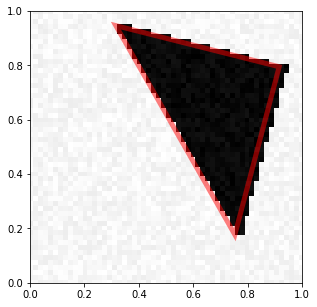

In [59]:
visualize_prediction(X_train[0], Y_train[0])

In [60]:
X_train.shape

(300, 5184)

In [61]:
Y_train.shape

(300, 6)

In [62]:
X_train = X_train.reshape(300, 72, 72, 1)

In [63]:
model6 = Sequential()
#add model layers
model6 = Sequential([
    Conv2D(64, kernel_size=3, activation='relu', input_shape=(72, 72, 1)),
    Conv2D(32, kernel_size=3, activation='relu'),
    Flatten(),
    Dense(6, activation='linear')])

model6.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [64]:
model6.fit(X_train, Y_train, epochs=15, validation_split = 0.2)

Train on 240 samples, validate on 60 samples
Epoch 1/15
240/240 [==============================] - 3s 13ms/step - loss: 12.7502 - acc: 0.1333 - val_loss: 8.5628 - val_acc: 0.0667
Epoch 2/15
240/240 [==============================] - 3s 12ms/step - loss: 12.7737 - acc: 0.1458 - val_loss: 5.2435 - val_acc: 0.0667
Epoch 3/15
240/240 [==============================] - 3s 13ms/step - loss: 5.3434 - acc: 0.1708 - val_loss: 5.2530 - val_acc: 0.1667
Epoch 4/15
240/240 [==============================] - 3s 14ms/step - loss: 5.3624 - acc: 0.1750 - val_loss: 5.2496 - val_acc: 0.1667
Epoch 5/15
240/240 [==============================] - 3s 12ms/step - loss: 5.3451 - acc: 0.1750 - val_loss: 5.2301 - val_acc: 0.1667
Epoch 6/15
240/240 [==============================] - 3s 13ms/step - loss: 5.3326 - acc: 0.1792 - val_loss: 5.2321 - val_acc: 0.1833
Epoch 7/15
240/240 [==============================] - 3s 13ms/step - loss: 5.3326 - acc: 0.1750 - val_loss: 5.2281 - val_acc: 0.1833
Epoch 8/15
240/240 [==

The results are not satisfactory and we will now perform normalisation.

In [65]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled = scaler.fit_transform(Y_train)
#unscaled = scaler.inverse_transform(scaled)

In [66]:
model7 = Sequential()
#add model layers
model7 = Sequential([
    Conv2D(64, kernel_size=3, activation='relu', input_shape=(72, 72, 1)),
    Conv2D(32, kernel_size=3, activation='relu'),
    Flatten(),
    Dense(6, activation='linear')])

model7.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [67]:
model7.fit(X_train, Y_train, epochs=15, validation_split = 0.2)

Train on 240 samples, validate on 60 samples
Epoch 1/15
240/240 [==============================] - 3s 14ms/step - loss: 12.6446 - acc: 0.1458 - val_loss: 10.1809 - val_acc: 0.0667
Epoch 2/15
240/240 [==============================] - 3s 12ms/step - loss: 11.4541 - acc: 0.1458 - val_loss: 9.8045 - val_acc: 0.0667
Epoch 3/15
240/240 [==============================] - 3s 11ms/step - loss: 17.6985 - acc: 0.1458 - val_loss: 6.4890 - val_acc: 0.0667
Epoch 4/15
240/240 [==============================] - 3s 11ms/step - loss: 5.6450 - acc: 0.1458 - val_loss: 5.2363 - val_acc: 0.0667
Epoch 5/15
240/240 [==============================] - 3s 12ms/step - loss: 5.3418 - acc: 0.1208 - val_loss: 5.2268 - val_acc: 0.1167
Epoch 6/15
240/240 [==============================] - 3s 11ms/step - loss: 5.3527 - acc: 0.1958 - val_loss: 5.2235 - val_acc: 0.2167
Epoch 7/15
240/240 [==============================] - 3s 12ms/step - loss: 5.3399 - acc: 0.2125 - val_loss: 5.2234 - val_acc: 0.2000
Epoch 8/15
240/240 [

In [563]:
[X_test, Y_test] = generate_test_set_regression()

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [564]:
model6.evaluate(X_test, Y_test)

300/300 [==============================] - 0s 106us/step


0.08268210897843042

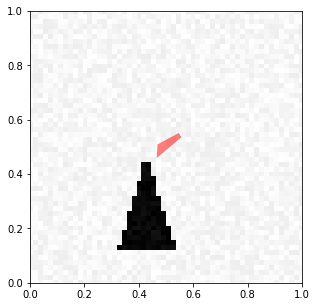

In [599]:
visualize_prediction(X_train[4], model6.predict(X_train[4].reshape(1, X_train[4].shape[0])))

In [579]:
model6.predict(X_test)

array([[0.5424148 , 0.4383538 , 0.46269566, 0.54540616, 0.5062677 ,
        0.39725077]], dtype=float32)

In [578]:
X_test = X_train[0].reshape(1, X_train[0].shape[0])